<a href="https://colab.research.google.com/github/RubenQuispe/Machine-Learning-con-Python-001/blob/master/Lab_13_SVM_Clasificador_c%C3%A9lulas_Malignas_Benignas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVM (Support Vector Machines) Para predecir Células Malignas & Benignas
## Creado por [M.Sc. Ruben Quispe](https://www.linkedin.com/in/msc-rub%C3%A9n-quispe-l/)

## Curso: [Machine Learning con Python](https://eie.pe/curso-machine-learning/)

En este notebook, aprenderás a usar SVM para contruir y entrenatr un modelo usando reistros de células humanas y clasificar las cálulas según si las muestras son malignas o benignas.

SVM funciona mapeando datos en un espacio de caractarísticas de alta dimensión para que los puntos de datos se puedan categorizar, incluso cuando  los datos no sean linealmente separarbles. Se encuentra un separador entre las categorias, luego los datos se transforman de tal manera que el separador se podria dibujar como un hiperplano. Despues de esto, las características de los nuevos datos se puede utilizar para predecir el grupo al que debe pertenecer un nuevo registro.

# Tabla de contenidos

1. Cargar la dataset de cancer
2. Modelado
3. Evaluación
4. Práctica
# 1. Importar las librerías necesarias

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

# 2.  Cargar la dataset de cancer
El ejemplo se basa en un dataset que esta disponible publicamente en el repositorio de ML de la UCI [Asuncion and Newman, 2007](https://cml.ics.uci.edu/MLRepository.html). El dataset consta de varios cientos de registros de muestras de células humanas, cada, cada uno de los cuales contiene los valores de un conjunto de características celulares. Lo campos de registro son:

|Field name|Description|
|--- |--- |
|ID|Clump thickness|
|Clump|Clump thickness|
|UnifSize|Uniformity of cell size|
|UnifShape|Uniformity of cell shape|
|MargAdh|Marginal adhesion|
|SingEpiSize|Single epithelial cell size|
|BareNuc|Bare nuclei|
|BlandChrom|Bland chromatin|
|NormNucl|Normal nucleoli|
|Mit|Mitoses|
|Class|Benign or malignant|

In [3]:
cell_df = pd.read_csv("D:/TECHNOLOGY 2020/Data/cell_samples.csv")

# 3. Explorar la data

In [4]:
# Leer el dataset
cell_df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


El campo ID contiene el identificador del paciente. Las características de las muestras de células de cada paciente estan contenidas en los campos de clump (agrupar) a Mit. Los valores se clasifican de 1 a 10, siendo 1 el más cercano a benigno.

El campo Class contiene el diagnóstico, confirmado por procedimientos médicos separados, de si las muestras son benignas (valor=2) o malignas (valor =4).

Veamosla distribución de las clases según al espesor del grupo y la uniformidad del tamaño de la celda.

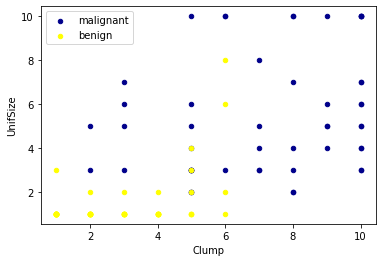

In [5]:
ax = cell_df[cell_df['Class'] == 4][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='DarkBlue', label='malignant');
cell_df[cell_df['Class'] == 2][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='Yellow', label='benign', ax=ax);
plt.show()

# 4. Pre-procesamiento y selección de Data 
Veamos el tipo de las columnas


In [6]:
cell_df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

Parece que la columna incluye algunos valores que no son numéricos.Podemos soltar(drop) esas filas

In [7]:
cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()]
cell_df['BareNuc']=cell_df['BareNuc'].astype('int')
cell_df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int32
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [8]:
feature_df=cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh','SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X= np.asanyarray(feature_df)
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]], dtype=int64)

Queremos que el modelo prediga el valor de clase (bening=2) o (malignant =4). Como este campo puede tener uno de los 2 valores posibles, necesitamos cambiar su nivel de medición para reflejarlo.

In [9]:
cell_df['Class']= cell_df['Class'].astype('int')
y = np.asanyarray(cell_df['Class'])
y[0:5]

array([2, 2, 2, 2, 2])

# 5. Train/Test Dataset
Bien dividimos nuestro data set en conjunto de train/test 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape, y_train.shape)
print('Test set: ', X_test.shape, y_test.shape)

Train set: (546, 9) (546,)
Test set:  (137, 9) (137,)


# 6. Modelos de SVM
El algoritmo de SVM ofrece una variedad de funciones de kernel para realizar su procesamiento. Básicamente, el mapeo de datos en un espacio de mayor dimesión se llama kernelling. La función matemática utilizada para la transformación se conoce como función de Kernel o nucleo y puede ser de diferentes tipos como:
1. Lineal
2. Polinomial
3. Función de Base Radial
4. Sigmoide

Cada una de estas funcionaes tiene sus características, pros y contras, y su ecuación, como no hay una manera fácil de saber qué función funciona mejor con un dataset dado, generalmente elegimos diferentes funciones a su vez y comparamos los resultados. Usalmos RBF predeterminada para este laboratorio. 

In [12]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

SVC()

In [13]:
# Una vez ajustado, el modelo se puede utilizar para predecir nuevos valores 
yhat=clf.predict(X_test)
yhat[0:5]

array([2, 4, 2, 4, 2])

# 7. Evaluación

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    esta fucnión imprime y grafica la matriz de confusión 
      La Normaliza se puede aplicar configurando 'normalize=True'
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137

Confusion matrix, without normalization
[[85  5]
 [ 0 47]]


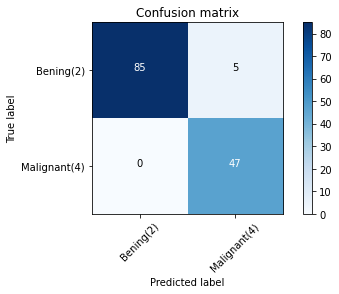

In [33]:
# Calculo de la confusion de matrix
cnf_matrix= confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# grafica de no normalizado de confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,classes =['Bening(2)', 'Malignant(4)'], normalize=False, title ='Confusion matrix')

También se puede usar fácilmente f1_score de la librería de sklearn

In [16]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted')


0.9639038982104676

Probemos el **jaccard index** para mayor precisión

In [21]:

#colab
#from sklearn.metrics import jaccard_similarity_score
#jaccard_similarity_score(y_test, yhat)
#local
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat)

ValueError: pos_label=1 is not a valid label: array([2, 4])

# Práctica
¿Puede reconstruir el modelo, pero esta vez con un kernel __linear__? Puede usar la opción __kernel = 'linear' __, cuando defina el archivo svm. ¿Cómo cambia la precisión con la nueva función del kernel?

In [20]:
# tu codigo
clf2 = svm.SVC(kernel='linear')
clf2.fit(X_train, y_train) 
yhat2 = clf2.predict(X_test)
print("Avg F1-score: %.4f" % f1_score(y_test, yhat2, average='weighted'))
print("Jaccard score: %.4f" % jaccard_similarity_score(y_test, yhat2))

Avg F1-score: 0.9639


NameError: name 'jaccard_similarity_score' is not defined

# Muchas gracias.